# Importing Libraries 

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Getting Data

In [2]:
df_1 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_2 = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
if 'SalePrice' not in df_2.columns:
    df_2['SalePrice'] = 0
df = pd.concat([df_1, df_2], axis = 0)
df = df.set_index('Id')

# EDA : Exploratory Data Analysis

In [25]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [26]:
df_null  = df[df.isnull().sum()[df.isnull().sum()>0].index]

In [5]:
df_null.head()

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
2,RL,80.0,NaN,AllPub,MetalSd,MetalSd,NaN,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
3,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
4,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,NaN,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
5,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD


In [28]:
df_objects =  df[df.select_dtypes(include=['object']).columns]
df = df.drop(df[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

In [29]:
df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

df_objects = df_objects.fillna('null')

df_objects_encoded = pd.get_dummies(df_objects)

In [8]:
df_objects['Utilities'].value_counts()

Utilities
AllPub    2916
null         2
NoSeWa       1
Name: count, dtype: int64

In [9]:
for i in df_objects_encoded.columns:
    if 'null' in i:
        df_objects_encoded = df_objects_encoded.drop(i, axis = 1)
        print(i)

MSZoning_null
Utilities_null
Exterior1st_null
Exterior2nd_null
BsmtQual_null
BsmtCond_null
BsmtExposure_null
BsmtFinType1_null
BsmtFinType2_null
Electrical_null
KitchenQual_null
Functional_null
GarageType_null
GarageFinish_null
GarageQual_null
GarageCond_null
SaleType_null


In [30]:
new_df = pd.concat([df, df_objects_encoded], axis = 1)

In [11]:
len(new_df.columns)

304

In [33]:
len(df.columns), len(df_objects_encoded.columns)

(74, 247)

In [34]:
new_df = new_df.drop(df.select_dtypes(include=['object']), axis = 1)

new_df.isna().sum()[new_df.isna().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [35]:
Mode_columns = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath']
Mean_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'GarageArea']

for i in Mode_columns:
    new_df[i] = new_df[i].fillna(new_df[i].mode()[0])

for i in Mean_columns:
    new_df[i] = new_df[i].fillna(np.round(new_df[i].mean()))

new_df.isna().sum()[new_df.isna().sum() > 0] 

Series([], dtype: int64)

# Plotting Graph and Plots

<Axes: ylabel='Id'>

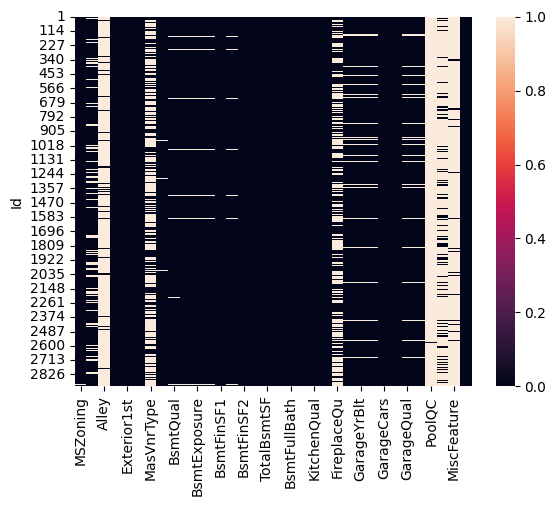

In [15]:
sns.heatmap(df_null.isnull())

# Splitting Data

In [16]:
training_data = new_df[0:len(df_1)]
testing_data = new_df[len(df_1):]
testing_data = testing_data.drop(columns='SalePrice')

In [17]:
X = training_data.drop(columns='SalePrice')
y = training_data['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)
Y_train = np.reshape(Y_train,(-1, 1))
Y_test = np.reshape(Y_test,(-1, 1))
X_train.shape, Y_train.shape

((1168, 266), (1168, 1))

# Trying Different Models

## Linear Regression

In [18]:
model_1 = LinearRegression()
model_1.fit(X, y)
y_pred = model_1.predict(X_test)
mean_squared_error(Y_test, y_pred)

472205357.27369606

## XGBoost

In [19]:
model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model_2.fit(X, y)
y_pred = model_2.predict(X_test)
mean_squared_error(Y_test, y_pred)

4749.173342508812

## Random Forest

In [20]:
model_3 = RandomForestRegressor(n_estimators=1000)
model_3.fit(X, y)
y_pred = model_3.predict(X_test)
mean_squared_error(Y_test, y_pred)

95178877.93532154

# Plotting Original vs Predicted Prices

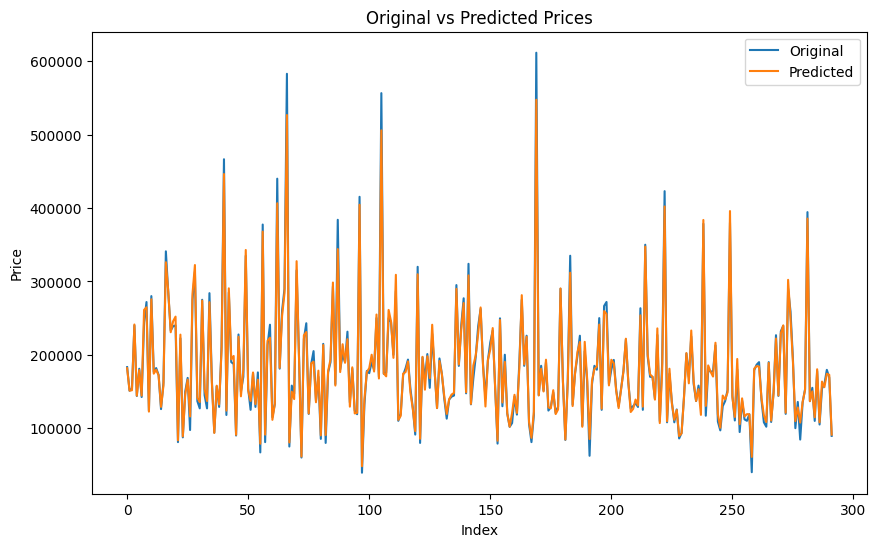

In [21]:
sort_indices = np.argsort(Y_test)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(Y_test)), Y_test, label='Original')
plt.plot(np.arange(len(Y_test)), y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Original vs Predicted Prices')
plt.legend()
plt.show()

In [22]:
pred = model_2.predict(testing_data)

final = pd.DataFrame()
final['Id'] = testing_data.index
final['SalePrice'] = pred

# Write DataFrame to a CSV file without index
final.to_csv('output.csv', index=False)